# SI 624 Final Project Code

### Part 1: Data and package imports

In [1]:
%pip install --no-deps "matplotlib==3.6.0"

Note: you may need to restart the kernel to use updated packages.


In [10]:
import os
from datetime import datetime
import imageio
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib
from matplotlib import transforms
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.colors as colors
import matplotlib.dates as mdates
from matplotlib.patches import Patch
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from jenkspy import JenksNaturalBreaks
from statsmodels.regression.linear_model import OLS
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from tqdm.notebook import tqdm

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [11]:
# social determinants of health
sdoh_df = pd.read_excel("./data/SDOH_2020_COUNTY_1_0.xlsx", sheet_name="Data")

# unemployment rate dataset
unemp_df = pd.read_excel(
    "./data/Unemployment.xlsx",
    sheet_name="UnemploymentMedianIncome",
    skiprows=[0, 1, 2, 3],
    header=None,
)
unemp_df = pd.DataFrame(unemp_df.values[1:], columns=unemp_df.iloc[0])

# poverty rate dataset
pov_df = pd.read_excel(
    "./data/PovertyEstimates.xlsx",
    sheet_name="PovertyEstimates",
    skiprows=[0, 1, 2, 3],
    header=None,
)
pov_df = pd.DataFrame(pov_df.values[1:], columns=pov_df.iloc[0])
pov_df['FIPS_Code'] = pov_df['FIPS_Code'].astype("float32")

# population estimate for 2020
pop_df = pd.read_excel(
    "./data/PopulationEstimates.xlsx",
    sheet_name="Population",
    skiprows=[0,1,2,3]
)

# geometry shape file - state level
sgdf = gpd.read_file("./data/cb_2022_us_state_500k/cb_2022_us_state_500k.shp")
sgdf = sgdf.drop(['ALAND', 'AWATER','GEOID', 'AFFGEOID', 'STATENS'], axis=1)


In [12]:
# opioid overdose death
death_df = pd.DataFrame()

for file in os.listdir("./data/WONDER"):
    if file[-3:] == "txt":
        temp = pd.read_csv(f"./data/WONDER/{file}", sep="\t")
        temp["year"] = int(file[-8:-4])
        # temp['Crude Rate'] = temp['Crude Rate'].replace("Unreliable", np.nan)
        temp.drop("Notes", axis=1, inplace=True)
        death_df = pd.concat([temp, death_df], axis=0)

death_df = (
    death_df.reset_index()
    .dropna(subset=["County", "County Code", "Deaths", "Population", "Crude Rate"])
    .drop("index", axis=1)
)

In [13]:
# Concatenate Opioid dispensing rate 2006-2020 data 
# set to True if we want to refresh CDC data source
REFRESH_OPIOID_SOURCE = False

# web-scraping from CDC website and save to directory
if REFRESH_OPIOID_SOURCE:
    for i in range(2006, 2021):
        print(f"at: {i}")
        df = pd.read_html(
            f"https://www.cdc.gov/drugoverdose/rxrate-maps/county{i}.html"
        )[0]
        df["year"] = i
        df.to_csv(f"./data/opioid_rx/{i}.csv")

# concatenate dataset
l = [
    pd.read_csv(f"./data/opioid_rx/{file}")
    for file in os.listdir("./data/opioid_rx")
    if file[-3:] == "csv"
]
df = pd.concat(l)

# fill empty year cells with 2020 (it gets omitted during data scraping due to source data formatting issues)
df["year"] = df["year"].fillna(2020)
# replace counties with no data with np.nan
df["Opioid Dispensing Rate per 100"] = (
    df["Opioid Dispensing Rate per 100"].replace("–", np.nan).astype("float32")
)
# The FIPS code for 2020 table has different name than other years
# account for this difference and combine 2020 FIPS code to "County FIPS Code" column
df["County FIPS Code"] = np.where(
    (df["year"] == 2020), df["State_County FIPS Code"], df["County FIPS Code"]
)

# Drop unused columns
df = df.reset_index().drop(
    ["Unnamed: 0", "index", "State_County FIPS Code", "State FIPS code"], axis=1
)

# 
df['Opioid Dispensing Rate per 100'] = df['Opioid Dispensing Rate per 100'].apply(lambda x: round(x, 2))

In [14]:
# mutate auxiliary dataframes to help count NA values in the dataset
pov_no_state = pov_df[np.where(pov_df["FIPS_Code"] % 1000 == 0, False, True)]
death_df_exp = death_df.copy()
death_df_exp["Crude Rate"] = death_df_exp["Crude Rate"].replace("Unreliable", pd.NA)

pd.DataFrame(
    {
        "Opioid Dispensing Data, 2006-2020": [
            df.shape,
            (df.isna().sum().sum() / (df.shape[0] * df.shape[1])) * 100,
        ],
        "Opioid Overdose Death Rate Data": [
            death_df_exp.shape,
            (
                death_df_exp.isna().sum().sum()
                / (death_df_exp.shape[0] * death_df_exp.shape[1])
            )
            * 100,
        ],
        "Poverty Estimates for the U.S., States and Counties": [
            pov_no_state.shape,
            (
                pov_df[np.where(pov_df["FIPS_Code"] % 1000 == 0, False, True)]
                .isna()
                .sum()
                .sum()
                / (pov_no_state.shape[0] * pov_no_state.shape[1])
            )
            * 100,
        ],
        "Population Estimates for the U.S. States, and Counties, 2021": [
            pop_df.shape,
            (pop_df.isna().sum().sum() / (pop_df.shape[0] * pop_df.shape[1])) * 100,
        ],
        "Unemployment and median household income for the U.S. 2000-2022": [
            unemp_df.shape,
            (unemp_df.isna().sum().sum() / (unemp_df.shape[0] * unemp_df.shape[1]))
            * 100,
        ],
        "Social Determinants of Health Database, 2020": [
            sdoh_df.shape,
            (sdoh_df.isna().sum().sum() / (sdoh_df.shape[0] * sdoh_df.shape[1])) * 100,
        ],
        "Cartographic Boundary Files - State Level": [
            sgdf.shape,
            (sgdf.isna().sum().sum() / (sgdf.shape[0] * sgdf.shape[1])) * 100,
        ],
    }
).T.rename(columns={0: "Shape (rows, cols)", 1: "% missing data"})

,"Shape (rows, cols)",% missing data
"Opioid Dispensing Data, 2006-2020","(46585, 5)",1.590641
Opioid Overdose Death Rate Data,"(8536, 6)",7.073961
"Poverty Estimates for the U.S., States and Counties","(3143, 34)",17.683554
"Population Estimates for the U.S. States, and Counties, 2021","(3283, 53)",2.305186
Unemployment and median household income for the U.S. 2000-2022,"(3277, 100)",0.377174
"Social Determinants of Health Database, 2020","(3229, 682)",9.145764
Cartographic Boundary Files - State Level,"(56, 5)",0.0


We investigated the missing data that exist in the varialbe we used and discovered that the missing data points are for 

### Question 1:

In [15]:
(
    # get the county with highest opioid dispensing rate
    df.loc[df.groupby('year')['Opioid Dispensing Rate per 100']
    .idxmax()].query('year == 2020')
)

,County,State,County FIPS Code,Opioid Dispensing Rate per 100,year
6021,NORTON CITY,VA,51720.0,406.7,2020.0


In [16]:
(
    df.query("year == 2020")
    .groupby("State")["Opioid Dispensing Rate per 100"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
    .head(5)
)

,State,Opioid Dispensing Rate per 100
0,AL,56.913433
1,AR,56.773333
2,TN,53.225263
3,KY,52.556303
4,GA,45.888462


In [17]:
# showing counties with highhest death rates
death_df.sort_values(by='Crude Rate', ascending=False).head(15)

,County,County Code,Deaths,Population,Crude Rate,year
0,"Baldwin County, AL",1003.0,10.0,179406.0,Unreliable,2009
9473,"Putnam County, FL",12107.0,16.0,74364.0,Unreliable,2010
9472,"Polk County, FL",12105.0,17.0,602095.0,Unreliable,2010
4916,"Portsmouth city, VA",51740.0,16.0,96201.0,Unreliable,2015
4914,"Newport News city, VA",51700.0,19.0,182385.0,Unreliable,2015
4911,"Warren County, VA",51187.0,12.0,39083.0,Unreliable,2015
4910,"Stafford County, VA",51179.0,15.0,142003.0,Unreliable,2015
4908,"Shenandoah County, VA",51171.0,10.0,43190.0,Unreliable,2015
4906,"Loudoun County, VA",51107.0,15.0,375629.0,Unreliable,2015
4904,"Hanover County, VA",51085.0,13.0,103227.0,Unreliable,2015


In [18]:
# showing counties with highest number of opioid deaths
death_df.sort_values(by='Deaths', ascending=False).head(15)

,County,County Code,Deaths,Population,Crude Rate,year
704,"Cook County, IL",17031.0,1662.0,5108284.0,32.54,2020
569,"Los Angeles County, CA",6037.0,1342.0,9943046.0,13.50,2020
545,"Maricopa County, AZ",4013.0,1255.0,4579081.0,27.41,2020
2995,"Cook County, IL",17031.0,1139.0,5150233.0,22.12,2019
5205,"Cook County, IL",17031.0,1041.0,5211263.0,19.98,2017
2192,"Cook County, IL",17031.0,1007.0,5180493.0,19.44,2018
6031,"Cook County, IL",17031.0,972.0,5203499.0,18.68,2016
1212,"Philadelphia County, PA",42101.0,913.0,1578487.0,57.84,2020
2859,"Maricopa County, AZ",4013.0,899.0,4485414.0,20.04,2019
3393,"Philadelphia County, PA",42101.0,813.0,1584064.0,51.32,2019


## Question 2

In [19]:
state_rx = df.groupby(['State', 'year'], as_index=False).agg({"Opioid Dispensing Rate per 100": "mean"})

jnb = JenksNaturalBreaks(5)
jnb.fit(state_rx['Opioid Dispensing Rate per 100'])

cls = []
for i in range(len(jnb.breaks_)):
     try: 
          a = str(round(jnb.breaks_[i], 1))
          b = str(round(jnb.breaks_[i+1], 1))
          cls.append(f"{a}-{b}")
     except:
          pass

state_rx['cls'] = state_rx['Opioid Dispensing Rate per 100'].apply(lambda x: "abcde"[jnb.predict(x)])
strx_gdf = sgdf[['STUSPS', 'geometry']].merge(state_rx, how="right", left_on="STUSPS", right_on="State")

In [20]:
# https://stackoverflow.com/questions/67575936/moving-alaska-and-hawaii-in-geopandas-for-choropleths
vmin = strx_gdf["Opioid Dispensing Rate per 100"].min()
vmax = strx_gdf["Opioid Dispensing Rate per 100"].max()

colmap = plt.cm.Reds

plot_color = [mcolors.to_hex(c) for c in colmap([0.2, 0.4, 0.6, 0.8, 1.0])]
color_dict = {i:c for i,c in zip("abcde", plot_color)}

plot_extra = True
for i in tqdm(range(2006, 2021)):
    # print(f"making {i} plot")
    fig, ax = plt.subplots(1, 1, figsize=(11, 9))

    filtered_data = filtered_data = strx_gdf[~(strx_gdf["State"].isin(["AK", "HI"])) & (strx_gdf["year"] == i)].to_crs(epsg=2163)
    filtered_data.plot(
        column="cls",
        categorical=True,
        color = filtered_data["cls"].map(color_dict),
        legend=True,
        ax=ax,
        legend_kwds={"frameon": False, "labels": cls, 'loc':'lower right'},
        edgecolor="k",
    )

    legend_patches = [Patch(color=color_dict[cls], label=cls) for cls in color_dict.keys()]
    ax.legend(handles=legend_patches, frameon=False, loc='lower right', labels=cls)

    ax.grid(False)
    ax.axis("off")
    ax.set_title(
        f"Opioid dispensing rate per 100 persons, {i}", fontdict={"fontsize": 25}
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    pos = ax.get_position()
    bottom_shifted = (
        pos.y0 + -0.15
    )  # This value can be adjusted as per the desired shift
    ax.set_position([pos.x0, bottom_shifted, pos.width, pos.height])

    ax_ak = fig.add_axes([0.1, 0.07, 0.2, 0.2])
    strx_gdf[(strx_gdf["State"] == "AK") & (strx_gdf["year"] == i)].to_crs(
        epsg=3338
    ).fillna(1e-6).plot(
        column="cls",
        categorical=True,
        # cmap=colors.ListedColormap(list(color_dict.values())),
        color = filtered_data["cls"].map(color_dict),
        ax=ax_ak,
        edgecolor="k",
    )
    ax_ak.set_title("Alaska")
    ax_ak.grid(False)
    ax_ak.axis("on")
    ax_ak.set_xticks([])
    ax_ak.set_yticks([])
    # set x, y boundary to ensure consistency across visualization
    ax_ak.set_xbound(-2.25e6, 1.5e6)
    ax_ak.set_ybound(0.37e6, 2.40e6)
    ax_ak.set_xticklabels([])
    ax_ak.set_yticklabels([])

    ax_hi = fig.add_axes([0.59, 0.05, 0.2, 0.2])
    strx_gdf[(strx_gdf["State"] == "HI") & (strx_gdf["year"] == i)].to_crs(
        epsg=4326
    ).fillna(1e-6).plot(
        column="cls",
        categorical=True,
        # cmap=colors.ListedColormap(list(color_dict.values())),
        color = filtered_data["cls"].map(color_dict),
        ax=ax_hi,
        edgecolor="k",
    )
    ax_hi.set_title("Hawaii")
    ax_hi.grid(False)
    ax_hi.axis("on")
    ax_hi.set_xticks([])
    ax_hi.set_yticks([])
    ax_hi.set_xticklabels([])
    ax_hi.set_yticklabels([])

    if plot_extra:
        #
        ax_pp = fig.add_axes([1, 0.58, 0.3, 0.27])
        mean_df = (
            strx_gdf.groupby("year")["Opioid Dispensing Rate per 100"]
            .mean()
            .reset_index()
        )
        ax_pp.plot_date(
            pd.to_datetime(i, format="%Y"),
            [mean_df.loc[i - 2006]["Opioid Dispensing Rate per 100"]],
            "go",
        )
        mean_df["year"] = pd.to_datetime(mean_df["year"], format="%Y")
        mean_df[["year", "Opioid Dispensing Rate per 100"]].plot(
            x="year", y="Opioid Dispensing Rate per 100", ax=ax_pp
        )
        ax_pp.set_title("Yearly trend of national mean dispensing rate")
        ax_pp.set_ylabel("Dispensing rate per 100 persons")
        ax_pp.annotate(
            f"{i} Mean: {str(round(mean_df.loc[i-2006]['Opioid Dispensing Rate per 100'], 1))}",
            xy=(pd.to_datetime(2007, format="%Y"), 45),
        )
        ax_pp.get_legend().remove()

        # histogram of dispensing rate of year
        ax_hist = fig.add_axes([1, 0.2, 0.3, 0.27])
        strx_gdf[strx_gdf["year"] == i]["Opioid Dispensing Rate per 100"].plot(
            kind="hist", ax=ax_hist, bins=15
        )
        ax_hist.set_title(f"Distribution of dispensing rate for {i}")
        ax_hist.set_xlim(0, vmax)
        ax_hist.set_ylim(0, 15)
        ax_hist.set_xlabel("Rate")

    plt.tight_layout()
    # plt.show()
    plt.savefig(f"./viz_raw/state_jnb/{i}.png", dpi=512, bbox_inches="tight", pad_inches=0.15)
    plt.close()

fname = "./visualization/2006-2020 state opioid dispensing rate.gif"

print("generating animation...")
with imageio.get_writer(fname, mode='I', duration=1000) as writer:
    for filename in tqdm(sorted([f for f in os.listdir(os.curdir + "/viz_raw/state_jnb/") if os.path.isfile(os.curdir + "/viz_raw/state_jnb/" + f)])):
        image = imageio.imread("./viz_raw/state_jnb/" + filename)
        writer.append_data(image)

  0%|          | 0/15 [00:00<?, ?it/s]

generating animation...


  0%|          | 0/15 [00:00<?, ?it/s]

In [21]:
# opioid overdose death
death_df = pd.DataFrame()

for file in os.listdir("./data/WONDER"):
    if file[-3:] == "txt":
        temp = pd.read_csv(f"./data/WONDER/{file}", sep="\t")
        temp["year"] = int(file[-8:-4])
        temp.drop("Notes", axis=1, inplace=True)
        death_df = pd.concat([temp, death_df], axis=0)

death_df = (
    death_df.reset_index()
    .dropna(subset=["County", "County Code", "Deaths", "Population", "Crude Rate"])
    .drop("index", axis=1)
)

death_df['State'] = death_df['County'].apply(lambda x: x.split(', ')[1])
# create place holder column to avoid states getting wipped out by accident
death_df['Rate'] = (death_df['Deaths'] / death_df['Population']) * 100000
death_df = death_df.drop(death_df[death_df['Crude Rate'] == 'Unreliable'].index)
death_df['Crude Rate'] = death_df['Crude Rate'].astype("float32")

jnb = JenksNaturalBreaks(5)
jnb.fit(death_df['Crude Rate'])

# generate a list of strings for the break ranges
cls = []
for i in range(len(jnb.breaks_)):
     try: 
          a = str(round(jnb.breaks_[i], 1))
          b = str(round(jnb.breaks_[i+1], 1))
          cls.append(f"{a}-{b}")
     except:
          pass

death_df['cls'] = death_df['Crude Rate'].apply(lambda x: "abcde"[jnb.predict(x)])

In [22]:
# 1. Create a complete list of state-year combinations
all_states = sgdf["STUSPS"].unique()
all_years = death_df["year"].unique()

# Cartesian product of states and years
state_years = pd.MultiIndex.from_product(
    [all_states, all_years], names=["State", "year"]
).to_frame(index=False)

# 2. Merge this list with your data
augmented_death_df = state_years.merge(death_df, on=["State", "year"], how="left")
augmented_death_df['Crude Rate'] = augmented_death_df['Crude Rate'].fillna(1e-3)
augmented_death_df['cls'] = augmented_death_df['cls'].fillna("x")

death_sgdf = sgdf.merge(
    (augmented_death_df.groupby(["State", "cls", "year"])["Crude Rate"].mean().reset_index()),
    how="left",
    left_on="STUSPS",
    right_on="State",
)

# dropping US Territories and commonwealth areas 
death_sgdf = death_sgdf.drop(
    death_sgdf[
        death_sgdf["STUSPS"].isin(['AS', 'GU', 'MP', 'PR', 'VI', 'UM'])
    ].index
)

In [23]:
# https://stackoverflow.com/questions/67575936/moving-alaska-and-hawaii-in-geopandas-for-choropleths
vmin = death_sgdf["Crude Rate"].min()
vmax = death_sgdf["Crude Rate"].max()

colmap = plt.cm.Reds

plot_color = [mcolors.to_hex(c) for c in colmap([0.2, 0.4, 0.6, 0.8, 1.0])] + [
    "#CCCCCC"
]
color_dict = {i: c for i, c in zip(['a', 'b', 'c', 'd', 'e', 'x'], plot_color)}

plot_extra = True
for i in tqdm(range(2006, 2021)):
    fig, ax = plt.subplots(1, 1, figsize=(11, 9))

    filtered_data = death_sgdf[
        ~(death_sgdf["State"].isin(["AK", "HI"])) & (death_sgdf["year"] == i)
    ].to_crs(epsg=2163)
    filtered_data.plot(
        column="cls",
        categorical=True,
        color=filtered_data["cls"].map(color_dict),
        legend=True,
        ax=ax,
        legend_kwds={"frameon": False, "labels": cls, "loc": "lower right"},
        edgecolor="k",
    )

    legend_patches = [
        Patch(color=color_dict[cls], label=cls) for cls in ['a', 'b', 'c', 'd', 'e']
    ]
    legend_patches.append(Patch(color="#CCCCCC", label="No data"))
    ax.legend(handles=legend_patches, frameon=False, loc="lower right", labels=cls + ['No data'])

    ax.grid(False)
    ax.axis("off")
    ax.set_title(f"Opioid Overdose Death Crude Rates, {i}", fontdict={"fontsize": 25})
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    pos = ax.get_position()
    bottom_shifted = (
        pos.y0 + -0.15
    )  # This value can be adjusted as per the desired shift
    ax.set_position([pos.x0, bottom_shifted, pos.width, pos.height])

    ax_ak = fig.add_axes([0.1, 0.07, 0.2, 0.2])
    death_sgdf[(death_sgdf["State"] == "AK") & (death_sgdf["year"] == i)].to_crs(
        epsg=3338
    ).fillna(1e-6).plot(
        column="cls",
        categorical=True,
        # cmap=colors.ListedColormap(list(color_dict.values())),
        color=filtered_data["cls"].map(color_dict),
        ax=ax_ak,
        edgecolor="k",
    )
    ax_ak.set_title("Alaska")
    ax_ak.grid(False)
    ax_ak.axis("on")
    ax_ak.set_xticks([])
    ax_ak.set_yticks([])
    # set x, y boundary to ensure consistency across visualization
    ax_ak.set_xbound(-2.25e6, 1.5e6)
    ax_ak.set_ybound(0.37e6, 2.40e6)
    ax_ak.set_xticklabels([])
    ax_ak.set_yticklabels([])

    ax_hi = fig.add_axes([0.59, 0.05, 0.2, 0.2])
    death_sgdf[(death_sgdf["State"] == "HI") & (death_sgdf["year"] == i)].to_crs(
        epsg=4326
    ).fillna(1e-6).plot(
        column="cls",
        categorical=True,
        # cmap=colors.ListedColormap(list(color_dict.values())),
        color=filtered_data["cls"].map(color_dict),
        ax=ax_hi,
        edgecolor="k",
    )
    ax_hi.set_title("Hawaii")
    ax_hi.grid(False)
    ax_hi.axis("on")
    ax_hi.set_xticks([])
    ax_hi.set_yticks([])
    ax_hi.set_xticklabels([])
    ax_hi.set_yticklabels([])

    if plot_extra:
        #
        ax_pp = fig.add_axes([1, 0.58, 0.3, 0.27])
        mean_df = death_sgdf.groupby("year")["Crude Rate"].mean().reset_index()
        ax_pp.plot_date(
            pd.to_datetime(i, format="%Y"),
            [mean_df.loc[i - 2006]["Crude Rate"]],
            "go",
        )
        mean_df["year"] = pd.to_datetime(mean_df["year"], format="%Y")
        mean_df[["year", "Crude Rate"]].plot(x="year", y="Crude Rate", ax=ax_pp)
        ax_pp.set_title("Yearly trend of\nnational mean opioid overdose death Crude Rate")
        ax_pp.set_ylabel("Crude death Crude Rate")
        ax_pp.annotate(
            f"{i} Mean: {str(round(mean_df.loc[i-2006]['Crude Rate'], 1))}",
            xy=(pd.to_datetime(2007, format="%Y"), 25),
        )
        ax_pp.set_ylim(0, 32)
        ax_pp.get_legend().remove()

        # histogram of death Crude Rate of year
        ax_hist = fig.add_axes([1, 0.2, 0.3, 0.27])
        death_sgdf[death_sgdf["year"] == i].groupby('State')["Crude Rate"].mean().plot(
            kind="hist", ax=ax_hist, bins=10
        )
        ax_hist.set_xlim(0, 159.6)
        ax_hist.set_ylim(0, 25)
        ax_hist.set_title(f"Distribution of death Crude Rate for {i}")
        ax_hist.set_xlabel("Crude Rate")

    plt.tight_layout()
    # plt.show()
    plt.savefig(f"./viz_raw/ood_jnp/{i}.png", dpi=512, bbox_inches="tight", pad_inches=0.15)
    plt.close()

fname = "./visualization/2006-2020 state opioid od Crude Rate.gif"

with imageio.get_writer(fname, mode='I', duration=1000) as writer:
    for filename in tqdm(sorted([f for f in os.listdir(os.curdir + "/viz_raw/ood_jnp/") if os.path.isfile(os.curdir + "/viz_raw/ood_jnp/" + f)])):
        image = imageio.imread("./viz_raw/ood_jnp/" + filename)
        writer.append_data(image)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

## Question 3

In [24]:
prescription_death_2006 = (
    df.query("year==2006")
    .merge(
        pop_df[["FIPStxt", "CENSUS_2020_POP"]],
        how="inner",
        right_on="FIPStxt",
        left_on="County FIPS Code",
    )
    .assign(census_base100=lambda x: x["CENSUS_2020_POP"] / 100)
    .assign(
        prescriptions=lambda x: round(
            x["Opioid Dispensing Rate per 100"] * x["census_base100"]
        )
    )
    .merge(
        death_df[["State", "year", "County Code", "Deaths", 'Crude Rate', "Rate"]].query(
            "year == 2020"
        ),
        how="inner",
        left_on="County FIPS Code",
        right_on="County Code",
    )
    # AMFAR_MEDSAFAC_RATE: Total number of substance abuse services facilities accepting Medicaid per 1,000 population
    # AMFAR_MEDMHFAC_RATE: Total number of facilities that provide mental health services and accept Medicaid per 1,000 population
    # ACS_GINI_INDEX: Gini index of income inequality
    .merge(
        sdoh_df[
            [
                "COUNTYFIPS",
                "AHRF_USDA_RUCC_2013",
                "AMFAR_MEDSAFAC_RATE",
                "AMFAR_MEDMHFAC_RATE",
                "SAIPE_MEDIAN_HH_INCOME",
                "ACS_GINI_INDEX",
                "SAIPE_PCT_POV",
            ]
        ],
        how="inner",
        left_on="County FIPS Code",
        right_on="COUNTYFIPS",
    )
    # .merge(pov_df[['FIPS_Code', 'POVALL_2021']], how = "inner", left_on = "County FIPS Code", right_on = 'FIPS_Code')
    .assign(
        ru_continuum=lambda x: np.where(x["AHRF_USDA_RUCC_2013"] >= 4, "Rural", "Urban")
    )
)

In [25]:
reg = prescription_death_2006[['Opioid Dispensing Rate per 100', 'Crude Rate']]
pipe = ColumnTransformer((
    ('prescription', StandardScaler(), reg.columns),
))

reg = pd.DataFrame(pipe.fit_transform(reg)).rename(columns={0: 'Opioid Dispensing Rate per 100', 1:'Crude Rate'})
smf.ols(formula="Q('Crude Rate')~Q('Opioid Dispensing Rate per 100')", data = reg).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Q('Crude Rate')   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     115.3
Date:                Fri, 01 Dec 2023   Prob (F-statistic):           1.11e-24
Time:                        22:21:00   Log-Likelihood:                -782.94
No. Observations:                 589   AIC:                             1570.
Df Residuals:                     587   BIC:                             1579.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                           -1.139e-17      0.038  -3.02e-16      1.000      -0.074       0.074
Q('Opioid Dispensing Rate per 100')     0.4052      0.038     10.738      0.000       0.331       0.479
==============================================================================
Omnibus:                      258.594   Durbin-Watson:                   1.304
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1576.077
Skew:                           1.853   Prob(JB):                         0.00
Kurtosis:                      10.105   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
prescription_death = (
    df.query("year==2020")
    .merge(
        pop_df[["FIPStxt", "CENSUS_2020_POP"]],
        how="inner",
        right_on="FIPStxt",
        left_on="County FIPS Code",
    )
    .merge(
        death_df[["State", "year", "County Code", "Deaths", 'Crude Rate']].query(
            "year == 2020"
        ),
        how="inner",
        left_on="County FIPS Code",
        right_on="County Code",
    )
    # AMFAR_MEDSAFAC_RATE: Total number of substance abuse services facilities accepting Medicaid per 1,000 population
    # AMFAR_MEDMHFAC_RATE: Total number of facilities that provide mental health services and accept Medicaid per 1,000 population
    # ACS_GINI_INDEX: Gini index of income inequality
    .merge(
        sdoh_df[
            [
                "COUNTYFIPS",
                "AHRF_USDA_RUCC_2013",
                "AMFAR_MEDSAFAC_RATE",
                "AMFAR_MEDMHFAC_RATE",
                "SAIPE_MEDIAN_HH_INCOME",
                "ACS_GINI_INDEX",
                "SAIPE_PCT_POV",
            ]
        ],
        how="inner",
        left_on="County FIPS Code",
        right_on="COUNTYFIPS",
    )
    # .merge(pov_df[['FIPS_Code', 'POVALL_2021']], how = "inner", left_on = "County FIPS Code", right_on = 'FIPS_Code')
    .assign(
        ru_continuum=lambda x: np.where(x["AHRF_USDA_RUCC_2013"] >= 4, "Rural", "Urban")
    )
)

In [27]:
reg = prescription_death[['Opioid Dispensing Rate per 100', 'Crude Rate']]
pipe = ColumnTransformer((
    ('prescription', StandardScaler(), reg.columns),
))

reg = pd.DataFrame(pipe.fit_transform(reg)).rename(columns={0: 'Opioid Dispensing Rate per 100', 1:'Crude Rate'})

smf.ols(formula="Q('Crude Rate')~Q('Opioid Dispensing Rate per 100')", data = reg).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Q('Crude Rate')   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     9.165
Date:                Fri, 01 Dec 2023   Prob (F-statistic):            0.00257
Time:                        22:21:00   Log-Likelihood:                -831.19
No. Observations:                 589   AIC:                             1666.
Df Residuals:                     587   BIC:                             1675.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                           -6.465e-19      0.041  -1.58e-17      1.000      -0.080       0.080
Q('Opioid Dispensing Rate per 100')     0.1240      0.041      3.027      0.003       0.044       0.204
==============================================================================
Omnibus:                      316.427   Durbin-Watson:                   1.145
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2359.217
Skew:                           2.296   Prob(JB):                         0.00
Kurtosis:                      11.663   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.07, 0.5, 'Crude Death Rate')

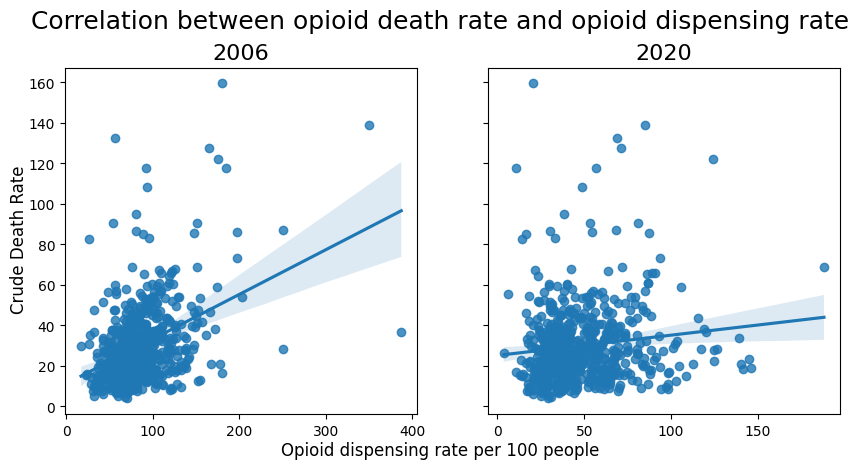

In [28]:
fig, ax = plt.subplots(1, 2, sharey = True, figsize=(10, 4.5))

sns.regplot(data=prescription_death_2006, x="Opioid Dispensing Rate per 100", y="Crude Rate", ax=ax[0])
sns.regplot(data=prescription_death, x="Opioid Dispensing Rate per 100", y="Crude Rate", ax=ax[1])
ax[0].set_xlabel("")
ax[0].set_ylabel("")
ax[0].set_title("2006", size=16)
ax[1].set_xlabel("")
ax[1].set_ylabel("")
ax[1].set_title("2020", size=16)
fig.suptitle("Correlation between opioid death rate and opioid dispensing rate", size=18, y=1.01)
fig.supxlabel("Opioid dispensing rate per 100 people", y = 0.01)
fig.supylabel("Crude Death Rate", x = 0.07)

## Question 4

In [29]:
# creating dataframe with only county and RUCC columns
rucc_df = sdoh_df[['COUNTYFIPS', 'AHRF_USDA_RUCC_2013']]

# converting FIPS code to float for merging purposes
rucc_df.loc[:, 'COUNTYFIPS'] = rucc_df['COUNTYFIPS'].astype(float)

# dropping columns with null values
rucc_df = rucc_df.dropna()

# RUCC codes 4-9 are typically considered rural
# labeling counties as rural or urban
rucc_df['Rural'] = rucc_df['AHRF_USDA_RUCC_2013'].apply(lambda x: 'Rural' if x >= 4 else 'Urban')
rucc_df.sample(5)

,COUNTYFIPS,AHRF_USDA_RUCC_2013,Rural
2202,40139.0,7.0,Rural
343,12045.0,3.0,Urban
529,13285.0,4.0,Rural
1134,22039.0,6.0,Rural
857,19133.0,6.0,Rural


In [30]:
# creating merged df with death and RUCC data
rucc_death_df = death_df.query('year == 2020').merge(rucc_df, left_on='County Code', right_on='COUNTYFIPS', how='left')

In [31]:
# descriptive statistics for opioid death rate by rural/urban county
rucc_death_df.groupby('Rural')['Crude Rate'].describe()

,count,mean,std,min,25%,50%,75%,max
Rural,,,,,,,,
Rural,63.0,46.772224,27.683161,17.780001,30.520000,37.720001,55.525000,159.610001
Urban,526.0,27.930569,17.511866,3.880000,16.074999,24.115000,35.267502,132.559998


In [32]:
# creating df with only geographic and rate of substance abuse facilities columns
mental_health_df = sdoh_df[["COUNTYFIPS", "STATE", "COUNTY", "AMFAR_MEDSAFAC_RATE"]]
mental_health_df.sample(5)

,COUNTYFIPS,STATE,COUNTY,AMFAR_MEDSAFAC_RATE
2198,40131,Oklahoma,Rogers County,0.0215
1417,28029,Mississippi,Copiah County,0.0358
717,18037,Indiana,Dubois County,0.0235
2278,42065,Pennsylvania,Jefferson County,0.0464
1352,27073,Minnesota,Lac qui Parle County,0.0000


In [33]:
# showing null values in dataset
mental_health_df.isnull().sum()

COUNTYFIPS             0
STATE                  0
COUNTY                 0
AMFAR_MEDSAFAC_RATE    9
dtype: int64

In [34]:
# dropping rows with null values
mental_health_df = mental_health_df.dropna(subset=["AMFAR_MEDSAFAC_RATE"])

# converting FIPS code to float for merging purposes
mental_health_df.loc[:, "COUNTYFIPS"] = mental_health_df.COUNTYFIPS.astype(float)

In [35]:
# merging overdose death and substance abuse facility rate dataframes
death_mental_df = death_df.query("year==2020").merge(
    mental_health_df, left_on="County Code", right_on="COUNTYFIPS", how="inner"
)
death_mental_df.sample(5)

,County,County Code,Deaths,Population,Crude Rate,year,State,Rate,cls,COUNTYFIPS,STATE,COUNTY,AMFAR_MEDSAFAC_RATE
362,"Rowan County, NC",37159.0,59.0,142495.0,41.400002,2020,NC,41.404962,c,37159.0,North Carolina,Rowan County,0.0211
141,"Winnebago County, IL",17201.0,130.0,281295.0,46.209999,2020,IL,46.214828,d,17201.0,Illinois,Winnebago County,0.0249
163,"Johnson County, KS",20091.0,53.0,607220.0,8.730000,2020,KS,8.728303,a,20091.0,Kansas,Johnson County,0.0198
338,"Catawba County, NC",37035.0,32.0,160307.0,19.959999,2020,NC,19.961698,b,37035.0,North Carolina,Catawba County,0.0499
317,"Oneida County, NY",36065.0,57.0,227346.0,25.070000,2020,NY,25.071917,b,36065.0,New York,Oneida County,0.0352


Text(0, 0.5, 'Opioid Overdose Death Rate per 100k People')

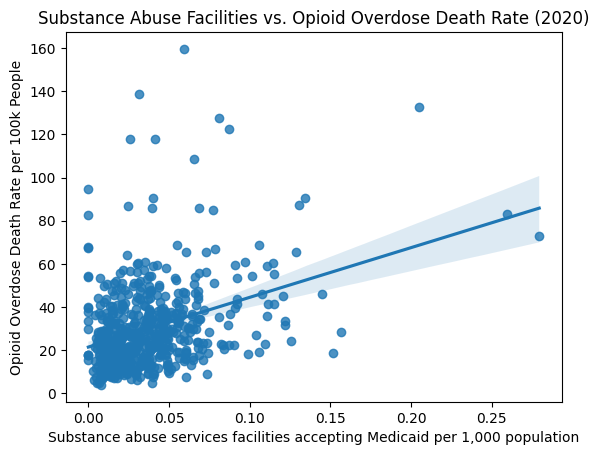

In [36]:
# creating regression plot of substance abuse facilities vs. opioid overdose death rate
sns.regplot(x='AMFAR_MEDSAFAC_RATE', y='Crude Rate', data=death_mental_df)
plt.title('Substance Abuse Facilities vs. Opioid Overdose Death Rate (2020)')
plt.xlabel('Substance abuse services facilities accepting Medicaid per 1,000 population')
plt.ylabel('Opioid Overdose Death Rate per 100k People')

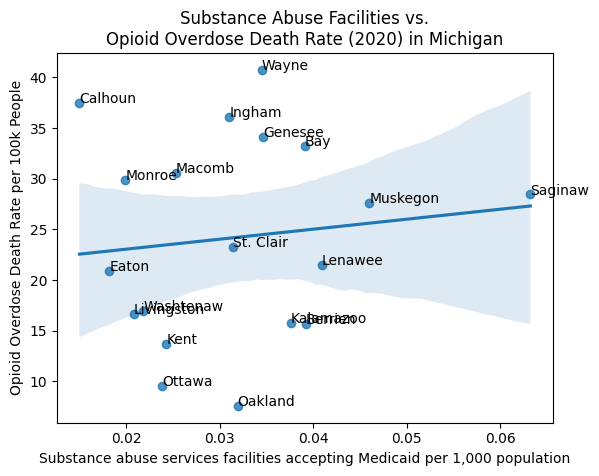

In [37]:
# creating regression plot of substance abuse facilities vs. opioid overdose death rate in Michigan
import random
michigan_df = death_mental_df[death_mental_df.STATE == "Michigan"]

sns.regplot(x="AMFAR_MEDSAFAC_RATE", y="Crude Rate", data=michigan_df)

# plotting county names on graph
for i in range(len(michigan_df)):
    plt.text(
        michigan_df["AMFAR_MEDSAFAC_RATE"].iloc[i],
        michigan_df["Crude Rate"].iloc[i],
        michigan_df["COUNTY"].iloc[i][:-7],
    )

plt.title(
    "Substance Abuse Facilities vs.\nOpioid Overdose Death Rate (2020) in Michigan"
)
plt.xlabel(
    "Substance abuse services facilities accepting Medicaid per 1,000 population"
)
plt.ylabel("Opioid Overdose Death Rate per 100k People");
# plt.legend()

In [38]:
# creating df with only geographic and percent of population in poverty columns
pov_df = sdoh_df[['COUNTYFIPS', 'STATE', 'COUNTY', 'SAIPE_PCT_POV']].copy()
pov_df.sample(5)

,COUNTYFIPS,STATE,COUNTY,SAIPE_PCT_POV
2858,51075,Virginia,Goochland County,5.8
123,5021,Arkansas,Clay County,18.1
766,18135,Indiana,Randolph County,12.4
1659,31007,Nebraska,Banner County,10.1
941,20103,Kansas,Leavenworth County,8.5


In [39]:
# dropping rows with null values
pov_df = pov_df.dropna(subset=['SAIPE_PCT_POV'])

# converting FIPS code to float for merging purposes
pov_df.loc[:, 'COUNTYFIPS'] = pov_df.COUNTYFIPS.astype(float)

In [40]:
# descriptive statistics for percent of population in poverty
pov_df.SAIPE_PCT_POV.describe()

count    3142.000000
mean       13.735360
std         5.422366
min         3.000000
25%         9.900000
50%        12.800000
75%        16.600000
max        43.900000
Name: SAIPE_PCT_POV, dtype: float64

In [41]:
# categorizing counties by percent of population in poverty
# low is less than or equal to 9.9% (25th percentile)
# high is greater than or equal to 16.6% (75th percentile)
pov_df['pov_cat'] = np.where(pov_df['SAIPE_PCT_POV'] <= 9.9, 'low', np.where(pov_df['SAIPE_PCT_POV'] >= 16.6, 'high', 'medium'))

In [42]:
# creating merged df with death and poverty data
death_pov_df = death_df.query("year == 2020").merge(pov_df, left_on='County Code', right_on='COUNTYFIPS', how='inner')
death_pov_df.sample(5)

,County,County Code,Deaths,Population,Crude Rate,year,State,Rate,cls,COUNTYFIPS,STATE,COUNTY,SAIPE_PCT_POV,pov_cat
104,"Santa Rosa County, FL",12113.0,39.0,189139.0,20.620001,2020,FL,20.619756,b,12113.0,Florida,Santa Rosa County,9.4,low
248,"Dakota County, MN",27037.0,40.0,431807.0,9.260000,2020,MN,9.263398,a,27037.0,Minnesota,Dakota County,4.8,low
365,"Union County, NC",37179.0,38.0,244562.0,15.540000,2020,NC,15.537982,b,37179.0,North Carolina,Union County,7.0,low
399,"Seneca County, OH",39147.0,23.0,54938.0,41.869999,2020,OH,41.865376,c,39147.0,Ohio,Seneca County,10.4,medium
125,"Ada County, ID",16001.0,52.0,494399.0,10.520000,2020,ID,10.517821,a,16001.0,Idaho,Ada County,7.7,low


Text(0, 0.5, 'Opioid Overdose Death Rate (per 100k People)')

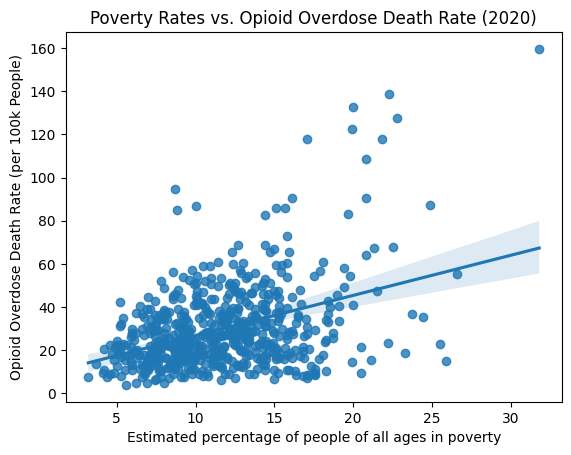

In [43]:
# creating regression plot of poverty rates vs. opioid overdose death rate
sns.regplot(x='SAIPE_PCT_POV', y='Crude Rate', data=death_pov_df)
plt.title('Poverty Rates vs. Opioid Overdose Death Rate (2020)')
plt.xlabel('Estimated percentage of people of all ages in poverty')
plt.ylabel('Opioid Overdose Death Rate (per 100k People)')

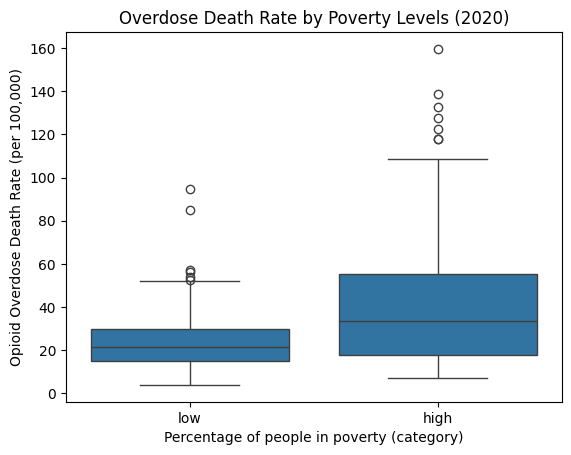

In [44]:
# filtering the data for low and high pov_cat (removing medium)
filtered_data = death_pov_df[death_pov_df['pov_cat'].isin(['low', 'high'])]

# creating boxplot of death rates by poverty levels
sns.boxplot(x='pov_cat', y='Crude Rate', data=filtered_data)
plt.title('Overdose Death Rate by Poverty Levels (2020)')
plt.xlabel('Percentage of people in poverty (category)')
plt.ylabel('Opioid Overdose Death Rate (per 100,000)');

## Question 5

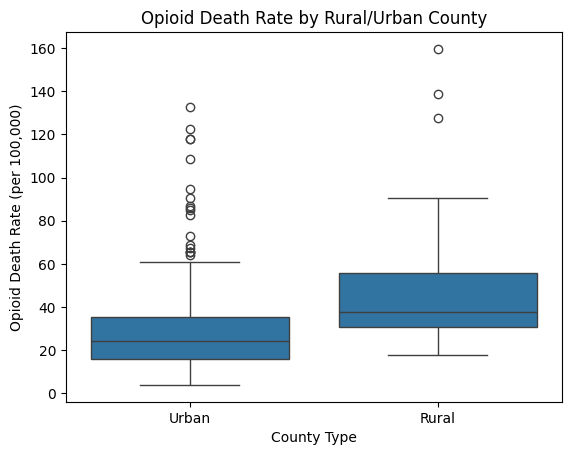

In [45]:
# Creating dataframe with only county and RUCC columns
rucc_df = sdoh_df[['COUNTYFIPS', 'AHRF_USDA_RUCC_2013']]
rucc_df.COUNTYFIPS = rucc_df.COUNTYFIPS.astype(float)
rucc_df = rucc_df.dropna()
# RUCC codes 4-9 are typically considered rural
rucc_df['Rural'] = rucc_df['AHRF_USDA_RUCC_2013'].apply(lambda x: 'Rural' if x >= 4 else 'Urban')
# Creating merged df with death and RUCC data
rucc_death_df = death_df.query("year == 2020").merge(rucc_df, left_on='County Code', right_on='COUNTYFIPS', how='left')
sns.boxplot(x="Rural", y="Crude Rate", data=rucc_death_df)
plt.title("Opioid Death Rate by Rural/Urban County")
plt.xlabel("County Type")
plt.ylabel("Opioid Death Rate (per 100,000)");

In [46]:
# Q5 Statistical tests
g1 = rucc_death_df["Deaths"][rucc_death_df["Rural"] == "Urban"]
g2 = rucc_death_df["Deaths"][rucc_death_df["Rural"] == "Rural"]


pd.DataFrame(
    {
        "Shapiro-Wilk's test of normality": stats.shapiro(rucc_death_df["Deaths"]),
        "Shapiro-Wilk's test of normality (Urban)": stats.shapiro(g1),
        "Shapiro-Wilk's test of normality (Rural)": stats.shapiro(g2),
        "Levene's test of homoscedasticity": stats.levene(g1, g2),
    },
    index=['Test Statistics', 'p-value']
).T

,Test Statistics,p-value
Shapiro-Wilk's test of normality,0.513096,2.810572e-37
Shapiro-Wilk's test of normality (Urban),0.533053,4.915756e-35
Shapiro-Wilk's test of normality (Rural),0.735969,2.566978e-09
Levene's test of homoscedasticity,12.545833,4.286233e-04


In [47]:
sm.stats.anova_oneway(
    data=rucc_death_df["Deaths"],
    groups=rucc_death_df["Rural"],
    use_var="unequal",
)

<class 'statsmodels.stats.base.HolderTuple'>
statistic = 119.91752062040705
pvalue = 1.7333177596467566e-25
df = (1.0, 577.6192673314)
df_num = 1.0
df_denom = 577.6192673314
nobs_t = 589.0
n_groups = 2
means = array([ 31.80952381, 108.65969582])
nobs = array([ 63., 526.])
vars_ = array([  206.18894009, 24184.03444867])
use_var = 'unequal'
welch_correction = True
tuple = (119.91752062040705, 1.7333177596467566e-25)

## Multiple regression

In [48]:
sdoh_reg = prescription_death[['Crude Rate', 'AMFAR_MEDSAFAC_RATE', 'AMFAR_MEDMHFAC_RATE', 'SAIPE_MEDIAN_HH_INCOME', 'ACS_GINI_INDEX', 'SAIPE_PCT_POV']]
pipe = ColumnTransformer((
    ('ss', StandardScaler(), sdoh_reg.columns),
))

sdoh_reg = pd.DataFrame(pipe.fit_transform(sdoh_reg), columns=pipe.named_transformers_.ss.get_feature_names_out())
sdoh_reg = pd.concat([sdoh_reg, prescription_death['ru_continuum']], axis=1)

smf.ols(formula="Q('Crude Rate') ~ + Q('AMFAR_MEDSAFAC_RATE') + Q('AMFAR_MEDMHFAC_RATE') + Q('SAIPE_MEDIAN_HH_INCOME') + Q('ACS_GINI_INDEX') + Q('SAIPE_PCT_POV') + C(ru_continuum)", data = sdoh_reg).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Q('Crude Rate')   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     34.61
Date:                Fri, 01 Dec 2023   Prob (F-statistic):           8.29e-36
Time:                        22:21:01   Log-Likelihood:                -745.90
No. Observations:                 589   AIC:                             1506.
Df Residuals:                     582   BIC:                             1536.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.4137      0.116      3.566      0.000       0.186       0.642
C(ru_continuum)[T.Urban]       -0.4633      0.124     -3.746      0.000      -0.706      -0.220
Q('AMFAR_MEDSAFAC_RATE')        0.1781      0.046      3.885      0.000       0.088       0.268
Q('AMFAR_MEDMHFAC_RATE')        0.0981      0.045      2.157      0.031       0.009       0.187
Q('SAIPE_MEDIAN_HH_INCOME')    -0.0663      0.060     -1.096      0.274      -0.185       0.053
Q('ACS_GINI_INDEX')            -0.0449      0.043     -1.040      0.299      -0.130       0.040
Q('SAIPE_PCT_POV')              0.2708      0.067      4.034      0.000       0.139       0.403
==============================================================================
Omnibus:                      221.469   Durbin-Watson:                   1.267
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1015.303
Skew:                           1.647   Prob(JB):                    3.39e-221
Kurtosis:                       8.524   Cond. No.                         7.27
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""